# MSc Mathematical Trading and Finance Dissertation Source Code

## Topic: Machine Learning Algorithms on Market Regimes Prediction

### Author: Jeffrey Tam

**Task**: Predict the market regime using machines learning algorithms from the raw data outlined from Two Sigma Factor Lens. Then, combine selected algorithms into an ensembled model and evaluate all of them.

**Labels**: 
1. <ins>crisis</ins>: any month with Equity return (obtained from MXCXDMHR) less than -0.05 and the subsequent 2 months
2. <ins>high inflation</ins>: any month with annual inflation (obtained from BCIT5T) more than or equal to 0.05
3. <ins>steady state</ins>: remaining months

**Features**: 
1. MSCI All-Country World Index 100% Hedged to USD (Bloomberg ticker: MXCXDMHR)
2. Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD (Bloomberg ticker: LGY7TRUH)
3. Bloomberg Barclays US Corporate (Bloomberg ticker: LUACTRUU)
4. Bloomberg Barclays US Corporate High Yield (Bloomberg ticker: LF98TRUU)
5. Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD (Bloomberg ticker: LP05TRUH)
6. Bloomberg Barclays Pan-European High Yield Hedged to USD (Bloomberg ticker: LP01TRUH)
7. Bloomberg Commodity Index (Bloomberg ticker: BCOMTR)
8. MSCI Emerging Markets Net Return Index (Bloomberg ticker: M1EF)
9. Bloomberg Barclays Emerging Markets USD Aggregate (Bloomberg ticker: EMUSTRUU)
10. MSCI Emerging Markets Currency Index (Bloomberg ticker: MXEF0CX0)
11. CBOE S&P 500 PutWrite Index (Bloomberg ticker: PUT)
12. Bloomberg GSAM FX G10 Value Index (Bloomberg ticker: BGSFXV)
13. Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years (Bloomberg ticker: BCIT5T)

**Base Models**:
* Multinominal Logistic Regression (L2)
* K-Nearest Neighbours (KNN)
* Decision Tree
* Random Forest
* ADA Boost
* Gradient Boost
* Support Vector Machines (SVMs)
* Linear Discriminant Analysis (LDA)
* Quadratic Discriminant Analysis (QDA)
* Naive Bayes

**Ensemble Models**:
<br>The ensemble model aggregates the predicted market regimes from the selected base models to generate a final prediction.
<br>The methodology is as follows:
1. Count the number of predictions for each market regime on each date.
2. Divide by the number of models to obtain the probability estimates for each market regime on each date.
3. Select the market regime with the highest probability estimate as the predicted label.

# Import Libraries

In [3]:
# For Data Preprocessing
from math import comb
from seaborn import pairplot
from sklearn.preprocessing import StandardScaler

# For Handling Imbalanced Data
from imblearn.under_sampling import EditedNearestNeighbours

# Supervised Learning
# For Logistic Regression
from sklearn.linear_model import LogisticRegression
# For K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
# For Decision Tree
from sklearn.tree import DecisionTreeClassifier
# For Random Forest
from sklearn.ensemble import RandomForestClassifier
# For ADA Boost
from sklearn.ensemble import AdaBoostClassifier
# For Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# For Support Vector Machines (SVMs)
from sklearn.svm import SVC
# For Linear Discriminant Analysis (LDA)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# For Quadratic Discriminant Analysis (QDA)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
# For Naive Bayes
from sklearn.naive_bayes import GaussianNB

# For Cross Validation
from sklearn.model_selection import GridSearchCV

# For calculating metrics
from ISLP import confusion_table
from sklearn.metrics import accuracy_score, recall_score

# Micro level ROC AUC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve

# For plotting
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# Load Data

In [5]:
# Define Bloomberg tickers in a list
tickers = ['MXCXDMHR', 'LGY7TRUH', 'LUACTRUU', 'LF98TRUU',
          'LP05TRUH', 'LP01TRUH', 'BCOMTR', 'M1EF',
          'EMUSTRUU', 'MXEF0CX0', 'PUT', 'BGSFXV', 'BCIT5T']

# Set the data file path
path = r"C:\Users\Jeffrey\SynologyDrive\Jeffrey\Master\Term 3\SMM527 Business Research Project for MSc FM, MTF and QF (PRD3 202324)\data"

In [6]:
# Load data file into a single DataFrame
df = pd.DataFrame(columns = ['date'])

for t in tickers:
    temp = pd.read_excel(path + f'\\{t}' + '.xlsx') # Read data
    temp = temp.iloc[5:] # Remove the top 5 rows as they are redundant
    temp.columns = ['date', t] # Change the column name
    df = df.merge(temp, how = 'outer', on = 'date') # Outer merge each loaded ticker into one single DataFrame
        
df.set_index('date', inplace = True) # Set the index
df.sort_values(by = 'date',inplace=True) # Sort the date in ascending order

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


# Data Preprocessing

## 1. Outlier Detection

In [9]:
# Check the number of observations and highest frequency
# The highest frequency is 2 in all dataset which is acceptable
df.describe()

,MXCXDMHR,LGY7TRUH,LUACTRUU,LF98TRUU,LP05TRUH,LP01TRUH,BCOMTR,M1EF,EMUSTRUU,MXEF0CX0,PUT,BGSFXV,BCIT5T
count,307.00,446,618.00,492.00,306.00,306.00,774.0000,283,378.0000,321.0,457.0,305.0000,329
unique,306.00,446,616.00,490.00,304.00,304.00,774.0000,283,378.0000,321.0,456.0,305.0000,329
top,144.24,100,137.79,536.47,253.46,156.96,1.9318,100,101.2867,652.4,831.1,99.2848,100
freq,2.00,1,2.00,2.00,2.00,2.00,1.0000,1,1.0000,1.0,2.0,1.0000,1


In [10]:
# Check if there exists a duplicated row
df.duplicated(keep = False).sum()

0

In [11]:
# Check for extreme values
df = df.astype(float) # Change the data type from categorical to float

# Check if there is outliers (i.e. observations that is 3 standard deviation from mean)
print((abs(df) > (df.mean() + 3 * df.std())).sum())

# Remove outliers
df = df[abs(df) < (df.mean() + 3 * df.std())]

# Fill the outliers with linaer interpolation
df.interpolate(inplace=True)

MXCXDMHR    0
LGY7TRUH    0
LUACTRUU    0
LF98TRUU    0
LP05TRUH    0
LP01TRUH    0
BCOMTR      1
M1EF        0
EMUSTRUU    0
MXEF0CX0    0
PUT         0
BGSFXV      0
BCIT5T      0
dtype: int64


## 2. Feature Engineering

In [13]:
# Calculate over-the-year inflation as a measure for annual inflation of the month for labelling market regime later
df['annual_inflation'] = df['BCIT5T'] / df['BCIT5T'].shift(12) - 1

In [14]:
# Calculate the percentage change
df.iloc[:,:-1] = df.iloc[:,:-1].pct_change()

## 3. Missing Values Handling

In [16]:
# drop any rows with missing values
df.dropna(inplace = True)

In [17]:
# Check for outliers again
# The number of observations is as expected, there are 283 months from Jan 2001 to Jun 2024
df.describe()

,MXCXDMHR,LGY7TRUH,LUACTRUU,LF98TRUU,LP05TRUH,LP01TRUH,BCOMTR,M1EF,EMUSTRUU,MXEF0CX0,PUT,BGSFXV,BCIT5T,annual_inflation
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.006162,0.003416,0.004001,0.006028,0.003535,0.006504,0.001911,0.008069,0.005706,0.002914,0.005476,0.002586,0.003902,0.049168
std,0.041288,0.011259,0.018288,0.026737,0.012949,0.029907,0.044717,0.060476,0.025884,0.017971,0.031580,0.018977,0.019053,0.066869
min,-0.163070,-0.030992,-0.077692,-0.159068,-0.067113,-0.141317,-0.212832,-0.273661,-0.194506,-0.075624,-0.176502,-0.063321,-0.093666,-0.138880
25%,-0.016529,-0.003668,-0.005677,-0.005716,-0.002988,-0.001561,-0.022502,-0.026210,-0.004092,-0.006235,-0.002122,-0.008816,-0.005742,0.001641
50%,0.013272,0.003431,0.004971,0.007739,0.004438,0.007001,0.002745,0.008000,0.007917,0.004169,0.010785,0.002164,0.005188,0.053511
75%,0.031961,0.010350,0.013686,0.017689,0.010722,0.018116,0.030622,0.047504,0.018081,0.013375,0.019694,0.015673,0.014232,0.097206
max,0.115193,0.041012,0.067965,0.121047,0.045625,0.147180,0.130045,0.170845,0.086914,0.051843,0.089780,0.063239,0.071109,0.188106


## 4. Data Labelling 
Market Regime is defined as following:
<br><ins>crisis</ins>: any month with Equity return (obtained from MXCXDMHR) less than -0.05 and the subsequent 2 months
<br><ins>high inflation</ins>: any month with annual inflation (obtained from BCIT5T) more than or equal to 0.05
<br><ins>steady state</ins>: remaining months

In [19]:
# Label market regime
df['market regime'] = np.select([df['MXCXDMHR'] <= -0.05,
                                 df['MXCXDMHR'].shift() <= -0.05,
                                 df['MXCXDMHR'].shift(2) <= -0.05,
                                 df['annual_inflation'] >= 0.05],
                                ['crisis', 'crisis', 'crisis', 'high inflation'], 'steady state')

df.drop('annual_inflation', axis = 1, inplace = True) # drop the column as it is no longer needed

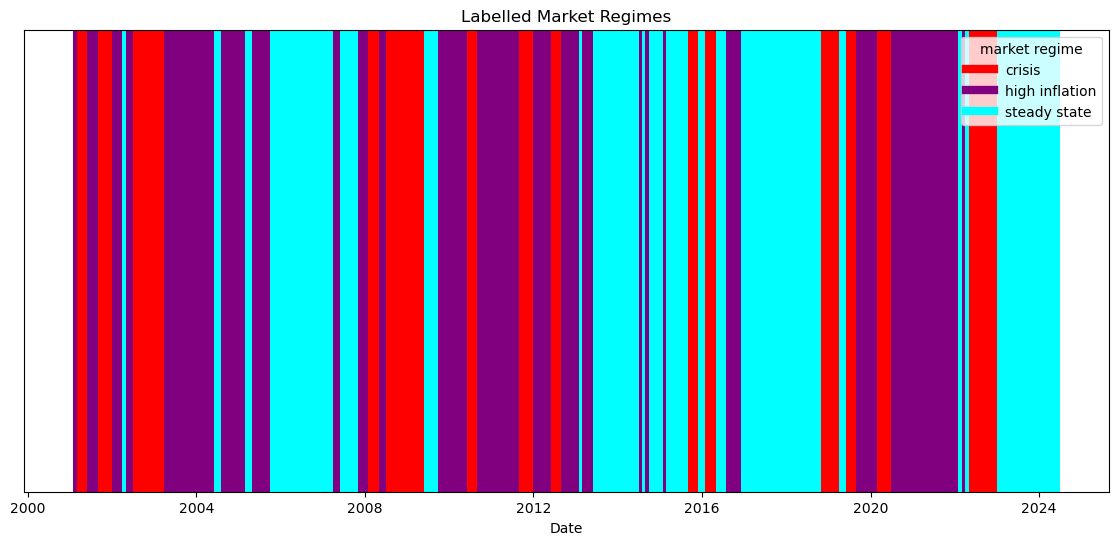

In [20]:
# Define colors for regimes
regime_colors = {'crisis': 'red', 'high inflation': 'purple', 'steady state': 'cyan'}

# Visualise the market regime over time
def visualise_market_regime(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Ensure data is sorted by date
    df = df.sort_index()
    
    # Initialize previous regime
    prev_regime = df.iloc[0]['market regime']
    prev_date = df.index[0]
    
    for date, regime in df.iterrows():
        if regime['market regime'] != prev_regime:
            # Draw horizontal line for the previous regime
            ax.hlines(10000, prev_date, date, colors=regime_colors[prev_regime], linewidth=500)
            prev_regime = regime['market regime']
            prev_date = date
    
    # Draw the last segment
    ax.hlines(10000, prev_date, df.index[-1], colors=regime_colors[prev_regime], linewidth=500)
    
    # Format the plot
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_yticks([])
    ax.legend(handles=[plt.Line2D([0], [0], color=color, lw=6) for color in regime_colors.values()],
               labels=regime_colors.keys(), title="market regime")
    plt.show()

# Call the function

visualise_market_regime(df, 'Labelled Market Regimes')

## 5. Exploratory Data Analysis

In [22]:
# Correlation matrix
df.corr(numeric_only=True)

,MXCXDMHR,LGY7TRUH,LUACTRUU,LF98TRUU,LP05TRUH,LP01TRUH,BCOMTR,M1EF,EMUSTRUU,MXEF0CX0,PUT,BGSFXV,BCIT5T
MXCXDMHR,1.000000,-0.080627,0.373783,0.724306,0.424563,0.684003,0.443833,0.817580,0.597168,0.609255,0.859113,0.015338,0.172660
LGY7TRUH,-0.080627,1.000000,0.658301,0.060097,0.611041,-0.009881,-0.160019,-0.050431,0.330646,0.043222,-0.108870,0.093234,0.676559
LUACTRUU,0.373783,0.658301,1.000000,0.613214,0.833860,0.500013,0.190407,0.423609,0.735754,0.431911,0.324628,-0.033218,0.740840
LF98TRUU,0.724306,0.060097,0.613214,1.000000,0.584132,0.879962,0.445105,0.710518,0.761979,0.606325,0.722659,-0.007821,0.383962
LP05TRUH,0.424563,0.611041,0.833860,0.584132,1.000000,0.587198,0.189769,0.392841,0.607701,0.382279,0.340079,-0.032444,0.568008
LP01TRUH,0.684003,-0.009881,0.500013,0.879962,0.587198,1.000000,0.380854,0.672938,0.647648,0.523476,0.660702,0.017918,0.227028
BCOMTR,0.443833,-0.160019,0.190407,0.445105,0.189769,0.380854,1.000000,0.556190,0.377121,0.555270,0.452667,-0.176976,0.251253
M1EF,0.817580,-0.050431,0.423609,0.710518,0.392841,0.672938,0.556190,1.000000,0.689839,0.820663,0.710091,-0.021782,0.254703
EMUSTRUU,0.597168,0.330646,0.735754,0.761979,0.607701,0.647648,0.377121,0.689839,1.000000,0.646093,0.584194,0.018671,0.564917
MXEF0CX0,0.609255,0.043222,0.431911,0.606325,0.382279,0.523476,0.555270,0.820663,0.646093,1.000000,0.552387,-0.173740,0.347822


In [23]:
# Percentage paris with absolute correlation > 0.7
# 15% is as expected as sample covariance matrix is a noisy statistics, which suffers from measurement error.
# Another reason is because there are 13 tickers in total but there is only 8 Two Sigma Names.
# 7 tickers belong to the 2 Two Sigma Names should be correlated  
(((abs(df.corr(numeric_only=True)) > 0.7).sum().sum() - len(tickers)) / 2) / comb(len(tickers),2)

0.15384615384615385

In [24]:
# Pairplot to check if the tickers are correlated and if the return distribution is normal
# pairplot(df, hue="market regime")

## 6. Lagged Variables Creation
Create a one-period lag for all features to prevent hindsight bias in the predictions.

In [26]:
df.iloc[:,:-1] = df.iloc[:,:-1].shift() # Create 1 lag period
df.dropna(inplace = True) # drop the top row with missing values

## 7. Data Splitting
The traning and testing dataset split on 2013-01-01 as this is approximately an even split of data

In [28]:
Xtrain = df[df.index < '2013-01-01'].iloc[:,:-1]
Ytrain = df[df.index < '2013-01-01'].iloc[:,-1]
Xtest = df[df.index >= '2013-01-01'].iloc[:,:-1]
Ytest = df[df.index >= '2013-01-01'].iloc[:,-1]

In [29]:
# View the number of market regimes in train set
Ytrain.value_counts(dropna=False)

market regime
high inflation    71
crisis            40
steady state      32
Name: count, dtype: int64

In [30]:
# View the number of market regimes in test set
Ytest.value_counts(dropna=False)

market regime
steady state      76
high inflation    36
crisis            26
Name: count, dtype: int64

## 8. Handling Imbalanced Data

In [32]:
Xtrain, Ytrain = EditedNearestNeighbours(sampling_strategy='not minority').fit_resample(Xtrain, Ytrain)

In [33]:
# View the number of market regimes in test set with ENN
Ytrain.value_counts(dropna=False)

market regime
steady state      32
crisis            14
high inflation    12
Name: count, dtype: int64

## 9. Normalisation
Scale training and testing features

In [35]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True) 
scaler.fit(Xtrain) # note here we use mean and std of training data to scale training and test data
Xtrain = pd.DataFrame(scaler.transform(Xtrain), columns = Xtrain.columns, index = Xtrain.index)
Xtest = pd.DataFrame(scaler.transform(Xtest), columns = Xtest.columns, index = Xtest.index)

# Base Models

### Multinominal Logistic Regression

In [38]:
# define the multinomial logistic regression model
logmodel = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1.0)

# set tuning values for Cross Validation
tuned_parameters = [{"C": [i/10 for i in np.logspace(-5, 1, 300)]}]

# tune the parameter by k-fold cross-validation
MLRcv = GridSearchCV(logmodel, tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
MLRcv.fit(Xtrain, Ytrain)

print(MLRcv.best_params_)

{'C': 0.757876886362593}


In [39]:
# predict the class label
yhat = MLRcv.predict(Xtest)

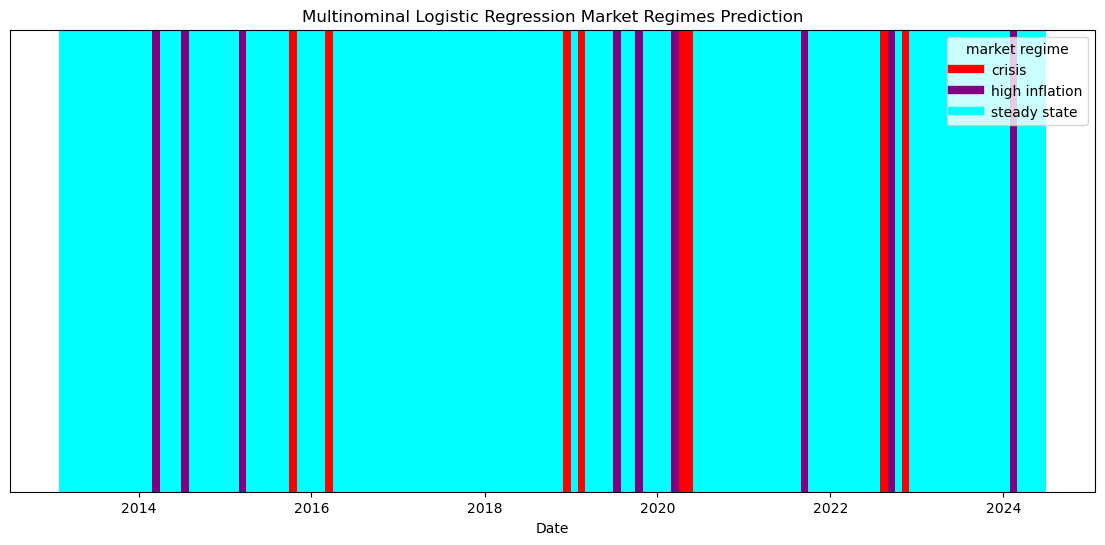

In [40]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Multinominal Logistic Regression Market Regimes Prediction')

In [41]:
# Macro level ROC AUC utility function
def individual_model_macro_ROC(X,y_true,model, model_name:str, ensemble_model:bool):
    """
    X: is the features for prediction
    y_true: the true labels
    model: classifier
    model_name: Name of the model
    ensemble_model: is it evaluting the ensemble model
    """
    # Source: # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    label_binarizer = LabelBinarizer().fit(Ytrain)
    y_onehot = label_binarizer.transform(y_true)

    if ensemble_model:
        y_score = ensembled_model_prediction(X, True)
    else:
        y_score = model.predict_proba(X)
    
    n_classes = len(np.unique(Ytrain))
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tpr = np.zeros_like(fpr_grid)
    
    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    
    # Average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    
    target_names = np.unique(Ytrain)
    
    colors = ["aqua", "darkorange", "cornflowerblue"]
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )
        
    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=model_name+"\nExtension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )

In [42]:
# This function contains all the evlaution metrics
def evaluation(X, y_true, model, ROC_AUC: bool = False, model_name: str = None):    
    """
    X: is the features for prediction
    y_true: the true labels 
    model: Classifier
    ROC_AUC: Print ROC AUC or not
    model_name: Name of the model
    """
    # Compute confusion table
    y_pred = model.predict(X)
    print(confusion_table(y_pred, y_true))
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Macro-recall
    macro_recall = recall_score(y_true, y_pred, labels=Ytrain.unique(),average='macro',zero_division=np.nan)
    # this reflects how well it is to data imbalance. In extreme case, 
    # when all predictions are the same as the most occurance label, the score will still be low
    
    print()
    
    print(pd.DataFrame({'accuracy': accuracy, 'macro recall':macro_recall},index=['score']))
    
    if ROC_AUC:
        print()
        individual_model_macro_ROC(X,y_true,model, model_name, False)

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0               8             0
steady state         0               4            32

       accuracy  macro recall
score  0.931034      0.888889



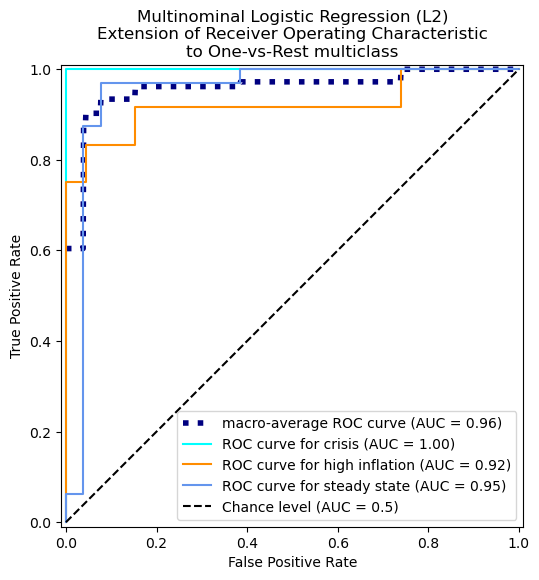

In [43]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, MLRcv, True, "Multinominal Logistic Regression (L2)")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis               8               0             0
high inflation       3               3             3
steady state        15              33            73

       accuracy  macro recall
score  0.608696      0.450517



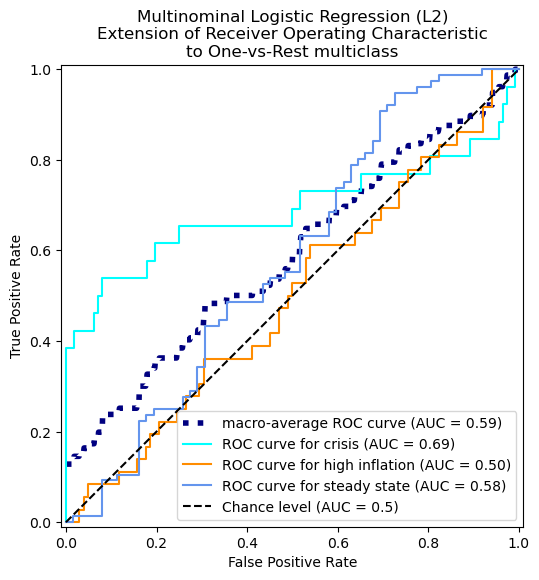

In [44]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, MLRcv, True, "Multinominal Logistic Regression (L2)")

### K-Nearest Neighbours

In [46]:
# set tuning values for Cross Validation
tuned_parameters = [{"n_neighbors": [i for i in range(1,51)]}]

# tune the parameter by k-fold cross-validation
knnCV = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
knnCV.fit(Xtrain, Ytrain)

print(knnCV.best_params_)

{'n_neighbors': 4}


In [47]:
# predict the class label
yhat = knnCV.predict(Xtest)

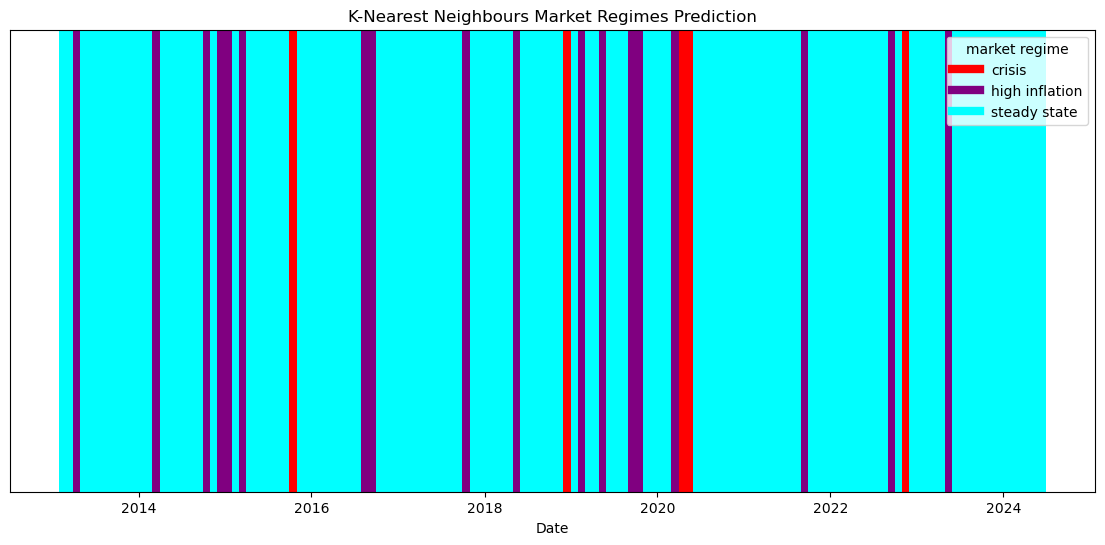

In [48]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'K-Nearest Neighbours Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              10             5
steady state         0               2            27

       accuracy  macro recall
score   0.87931      0.892361



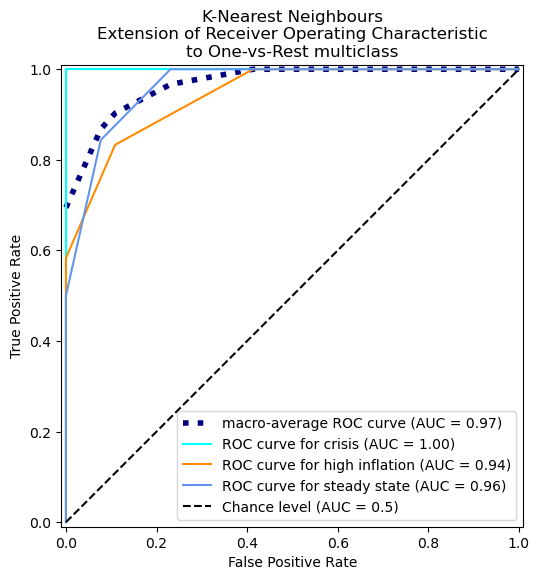

In [49]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, knnCV, True, "K-Nearest Neighbours")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis               5               0             0
high inflation       3               6             9
steady state        18              30            67

       accuracy  macro recall
score  0.565217      0.413518



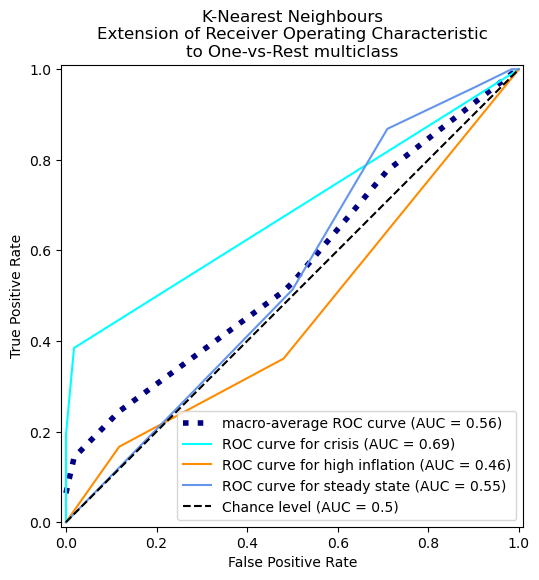

In [50]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, knnCV, True, "K-Nearest Neighbours")

### Decision Tree

In [52]:
# set tuning values for Cross Validation
tuned_parameters = [{"ccp_alpha": [1,0.1,0.01,0.001,0.0001]}]

# Apply Cross Validation
treeCV = GridSearchCV(DecisionTreeClassifier(random_state=0), tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
treeCV.fit(Xtrain, Ytrain)

print(treeCV.best_params_)

{'ccp_alpha': 0.01}


In [53]:
# predict the class label
yhat = treeCV.predict(Xtest)

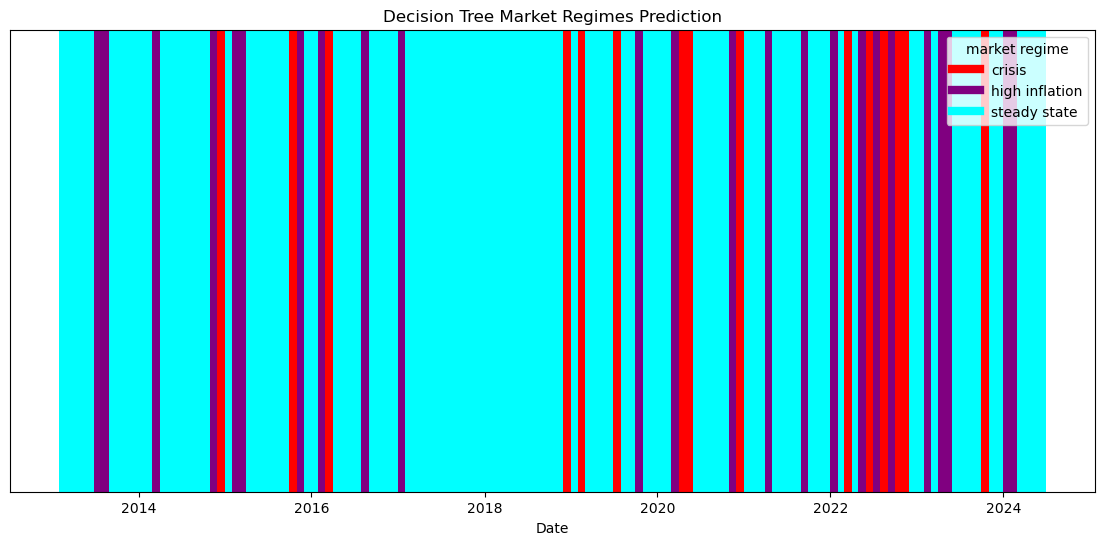

In [54]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Decision Tree Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

       accuracy  macro recall
score       1.0           1.0



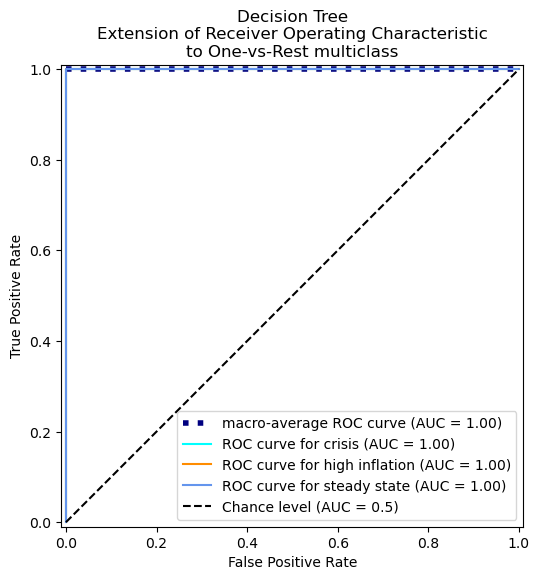

In [55]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, treeCV, True, "Decision Tree")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              11               2             2
high inflation       6               7            11
steady state         9              27            63

       accuracy  macro recall
score  0.586957      0.482156



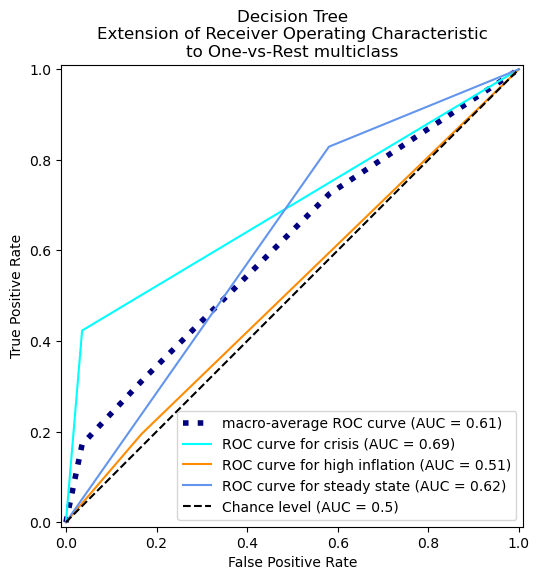

In [56]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, treeCV, True, "Decision Tree")

### Random Forest

In [58]:
# set tuning values for Cross Validation
tuned_parameters = [{"max_features": [5,10,"sqrt"], "n_estimators": [i for i in range(10,51,10)], "max_depth": [i for i in range(2,6,1)], "max_samples":[i for i in range(3,6,1)]}]

# tune the parameter by k-fold cross-validation
rfCV = GridSearchCV(RandomForestClassifier(bootstrap=True,oob_score=True,random_state=0), tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
rfCV.fit(Xtrain, Ytrain)

print(rfCV.best_params_)

{'max_depth': 2, 'max_features': 10, 'max_samples': 5, 'n_estimators': 10}


In [59]:
# predict the class label
yhat = rfCV.predict(Xtest)

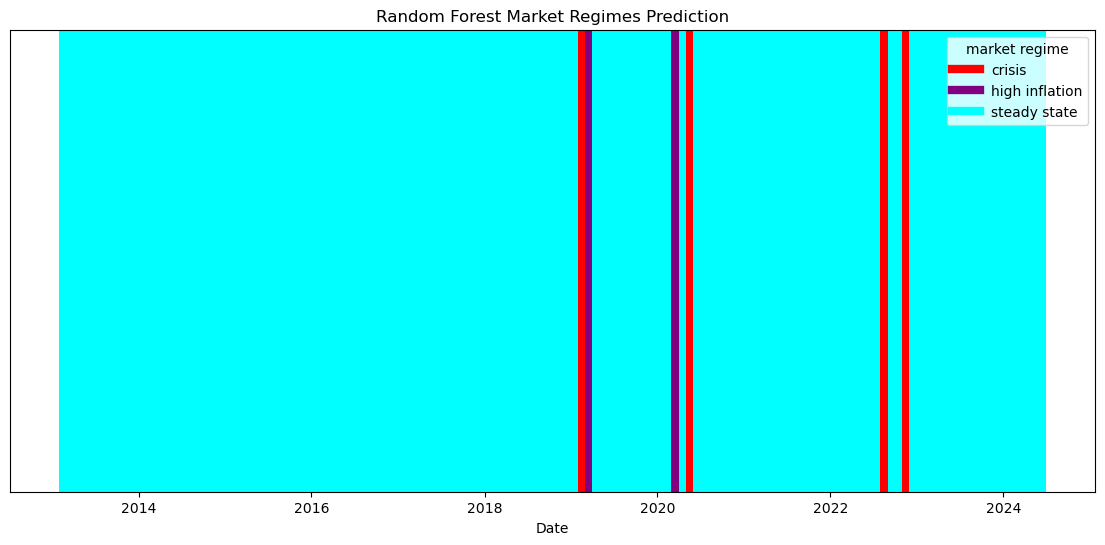

In [60]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Random Forest Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis               7               0             0
high inflation       0               0             0
steady state         7              12            32

       accuracy  macro recall
score  0.672414           0.5



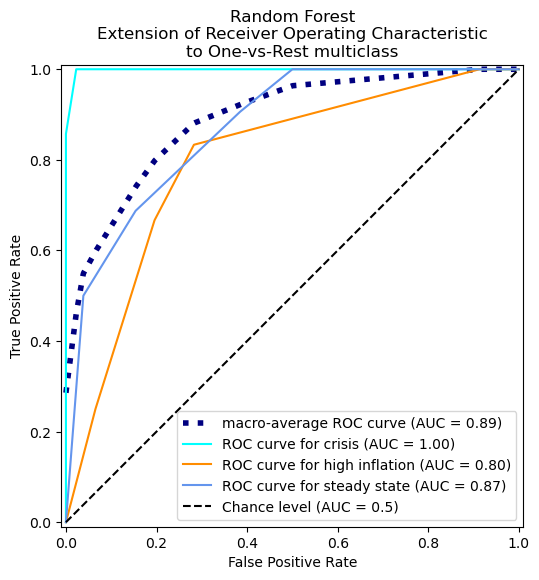

In [61]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, rfCV, True, "Random Forest")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis               4               0             0
high inflation       2               0             0
steady state        20              36            76

       accuracy  macro recall
score   0.57971      0.384615



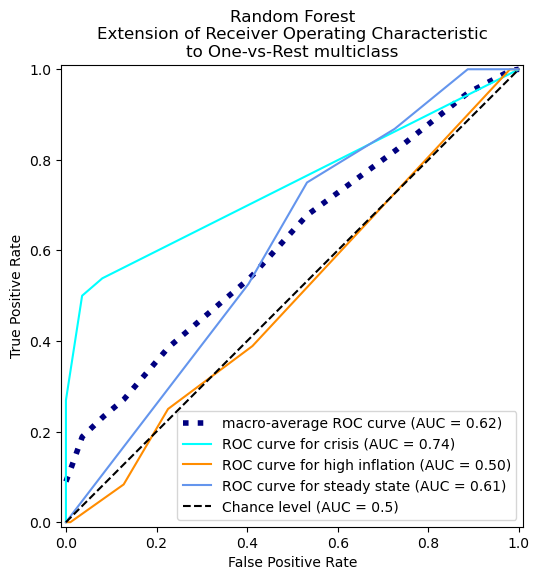

In [62]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, rfCV, True, "Random Forest")

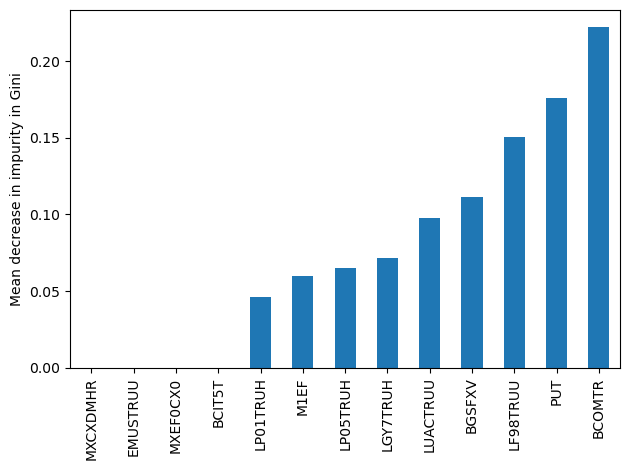

In [63]:
# get variable importance, e.g. mean decrease in gini index
# The larger n mean decrease in gini index, the more important the variable
rf = RandomForestClassifier(max_samples=rfCV.best_params_['max_samples'], max_depth=rfCV.best_params_['max_depth'], n_estimators=rfCV.best_params_['n_estimators'],max_features=rfCV.best_params_['max_features'],bootstrap=True,oob_score=True,random_state=0).fit(Xtrain,Ytrain)
rf_importances = rf.feature_importances_

#plot the most important features
index = np.argsort(rf_importances)
forest_importances = pd.Series(rf_importances[index], index=rf.feature_names_in_[index])

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity in Gini")
fig.tight_layout()

### AdaBoost

In [65]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6), n_estimators=100, random_state=0, algorithm='SAMME')

# set tuning values for Cross Validation
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]

# tune the parameter by k-fold cross-validation
adaCV = GridSearchCV(ada, tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
adaCV.fit(Xtrain, Ytrain)

print(adaCV.best_params_)

{'learning_rate': 0.001}


In [66]:
# predict the class label
yhat = adaCV.predict(Xtest)

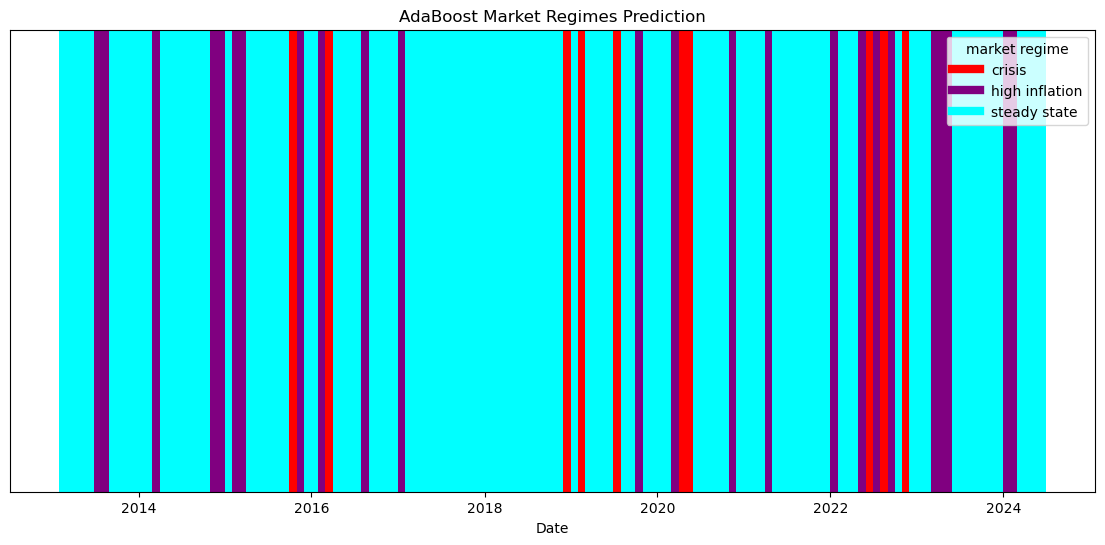

In [67]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'AdaBoost Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

       accuracy  macro recall
score       1.0           1.0



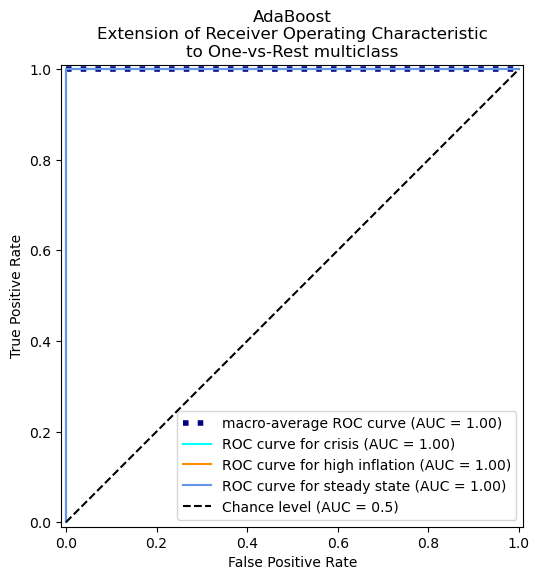

In [68]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, adaCV, True, "AdaBoost")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              10               0             0
high inflation       6               6            12
steady state        10              30            64

       accuracy  macro recall
score   0.57971      0.464462



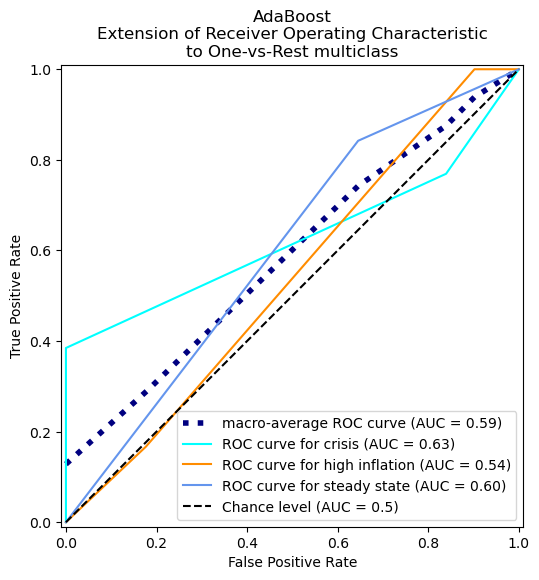

In [69]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, adaCV, True, "AdaBoost")

### Gradient Boost

In [71]:
grd = GradientBoostingClassifier(max_depth=5, n_estimators=100, random_state=0)

# set tuning values for Cross Validation
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]

# tune the parameter by k-fold cross-validation
grdCV = GridSearchCV(grd, tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
grdCV.fit(Xtrain, Ytrain)

print(grdCV.best_params_)

{'learning_rate': 1}


In [72]:
# predict the class label
yhat = grdCV.predict(Xtest)

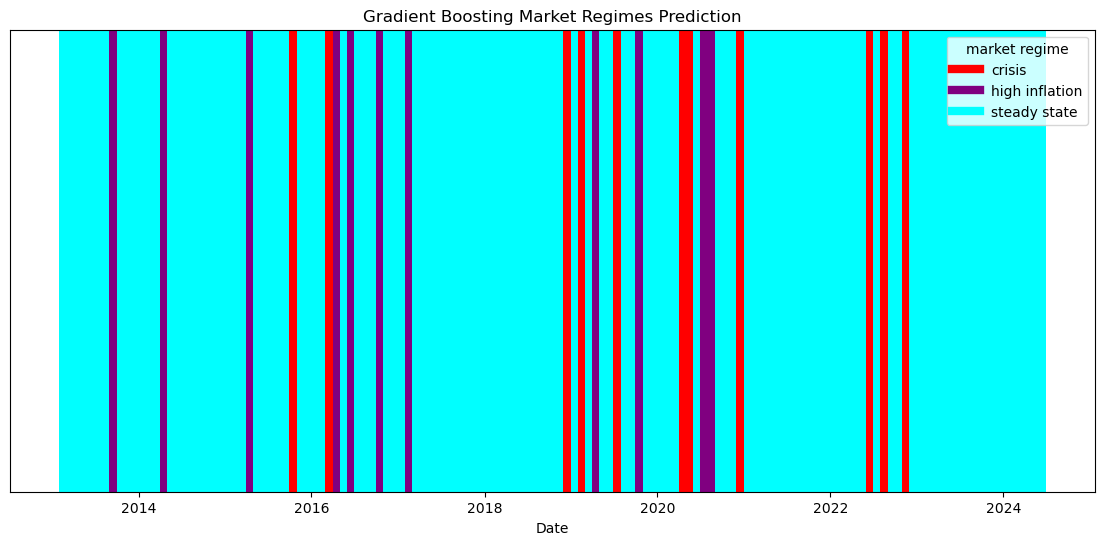

In [73]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Gradient Boosting Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

       accuracy  macro recall
score       1.0           1.0



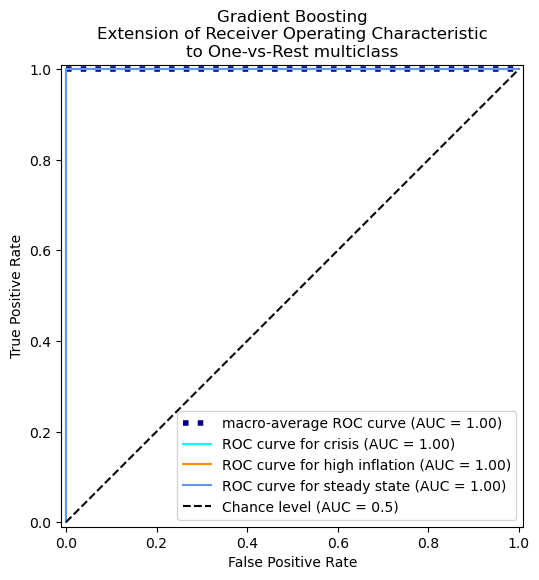

In [74]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, grdCV, True, "Gradient Boosting")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              10               1             0
high inflation       1               4             6
steady state        15              31            70

       accuracy  macro recall
score  0.608696       0.47226



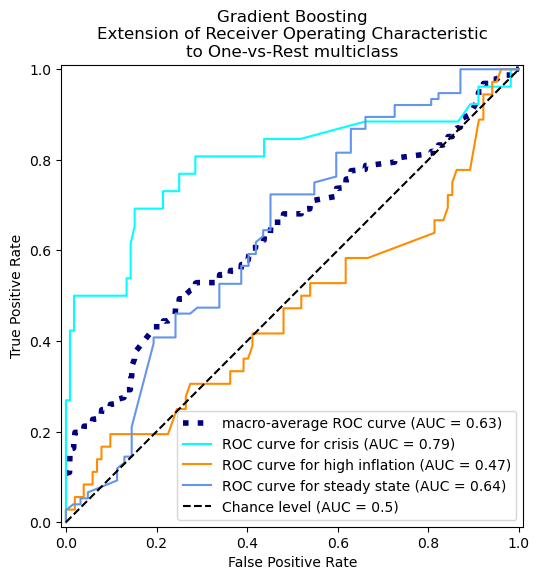

In [75]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, grdCV, True, "Gradient Boosting")

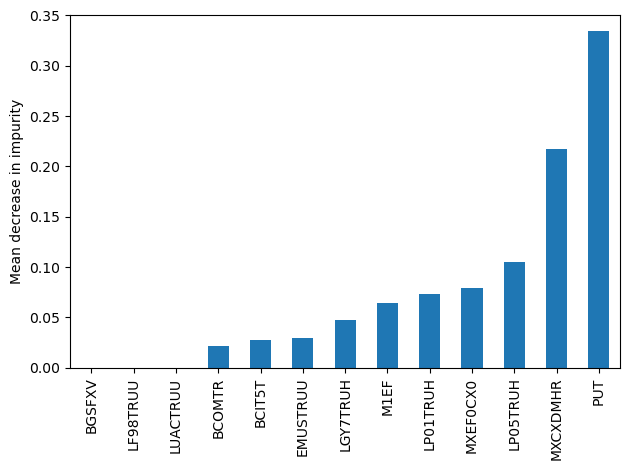

In [76]:
# get variable importance, e.g. mean decrease in gini index
# The larger n mean decrease in gini index, the more important the variable
grd = GradientBoostingClassifier(learning_rate=grdCV.best_params_['learning_rate'], max_depth=5, n_estimators=100, random_state=0).fit(Xtrain,Ytrain)
grd_importances = grd.feature_importances_

# plot the most important features
grd_index = np.argsort(grd_importances)
boosting_importances = pd.Series(grd_importances[grd_index], index=grd.feature_names_in_[grd_index])

fig, ax = plt.subplots()
boosting_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Support Vector Machines (SVMs)

In [78]:
# set tuning values for Cross Validation
tuned_parameters = [{"gamma": [1,1e-1,1e-2,1e-3, 1e-4], "C": [1, 10, 100,1000]}]

# tune the parameter by k-fold cross-validation
svmCV = GridSearchCV(SVC(), tuned_parameters, scoring='recall_macro',cv=10,n_jobs=-1)
svmCV.fit(Xtrain, Ytrain)

print(svmCV.best_params_)

{'C': 1000, 'gamma': 0.01}


In [79]:
# predict the class label
yhat = svmCV.predict(Xtest)

In [80]:
# Recreate the model with best params
svmCV = SVC(kernel='rbf',C=svmCV.best_params_['C'],gamma=svmCV.best_params_['gamma'],probability=True).fit(Xtrain,Ytrain)

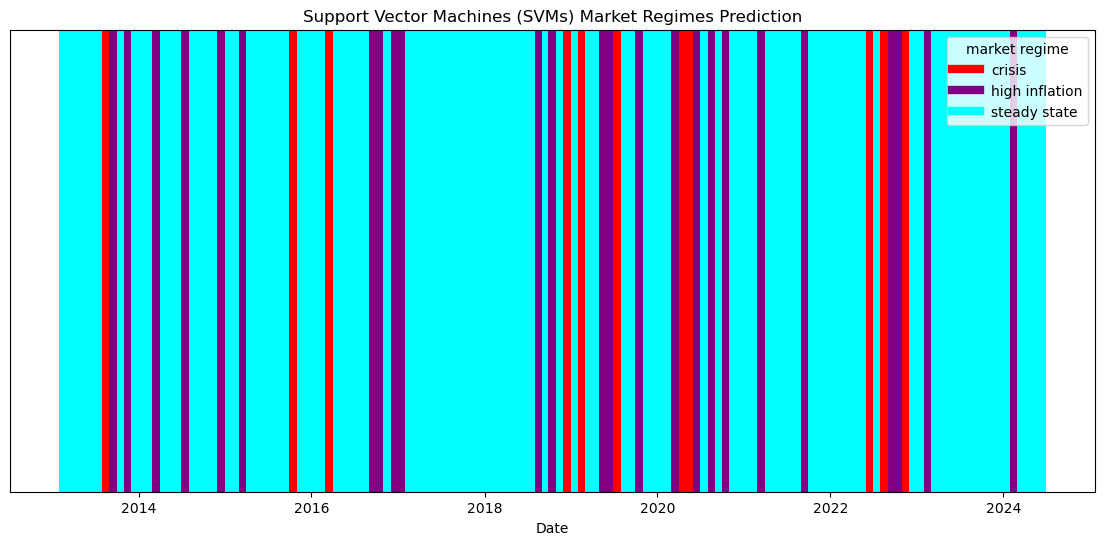

In [81]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Support Vector Machines (SVMs) Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

       accuracy  macro recall
score       1.0           1.0



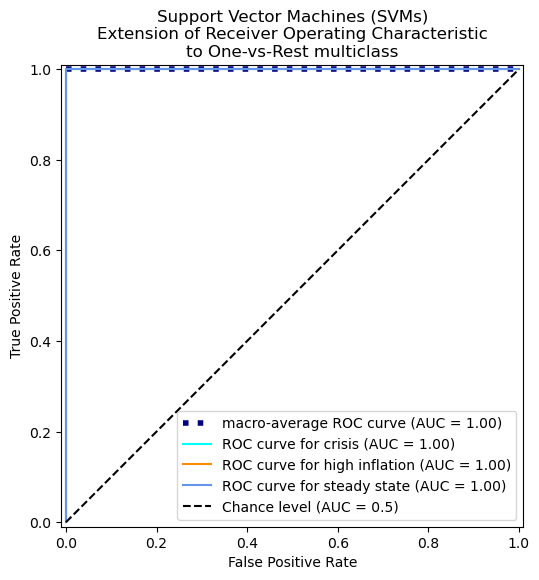

In [82]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, svmCV, True, "Support Vector Machines (SVMs)")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              10               0             1
high inflation       5               8            12
steady state        11              28            63

       accuracy  macro recall
score  0.586957      0.478595



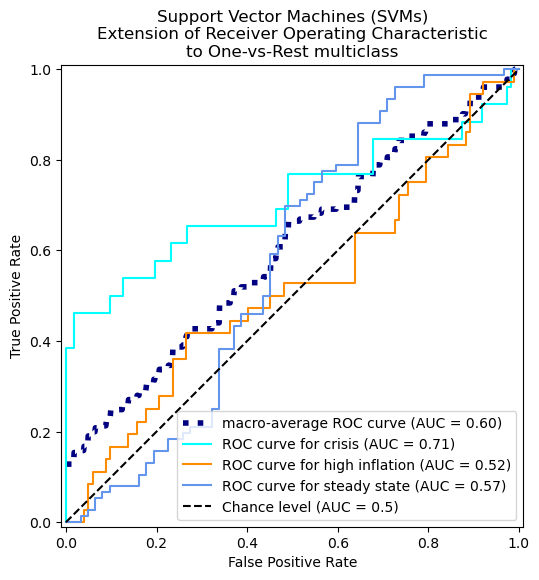

In [83]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, svmCV, True, "Support Vector Machines (SVMs)")

### Linear Discriminant Analysis (LDA)

In [85]:
# Apply LDA
lda = LDA()
lda.fit(Xtrain,Ytrain)

LinearDiscriminantAnalysis()

In [86]:
# predict the class label
yhat = lda.predict(Xtest)

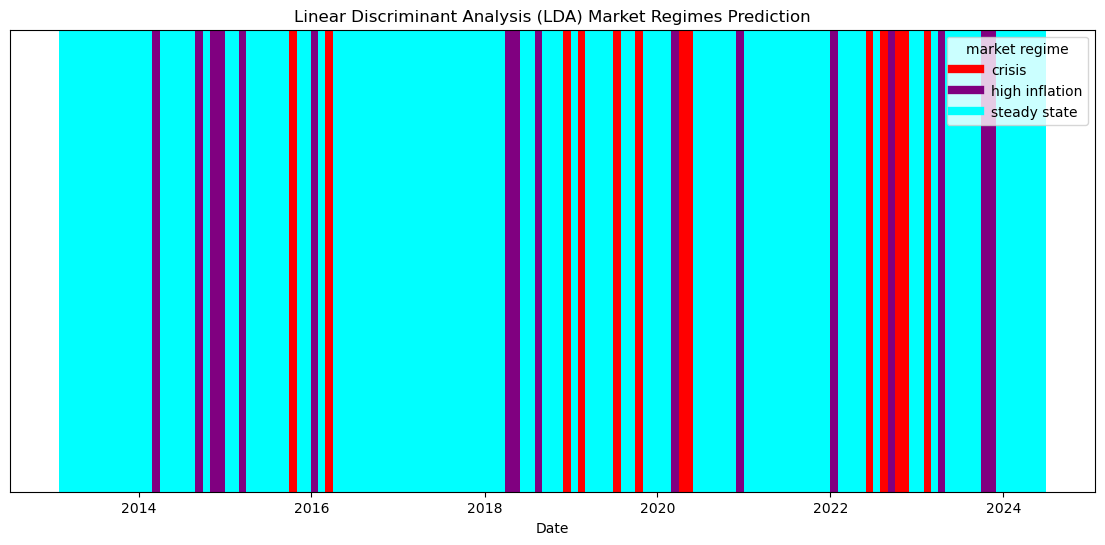

In [87]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Linear Discriminant Analysis (LDA) Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0               9             2
steady state         0               3            30

       accuracy  macro recall
score  0.913793      0.895833



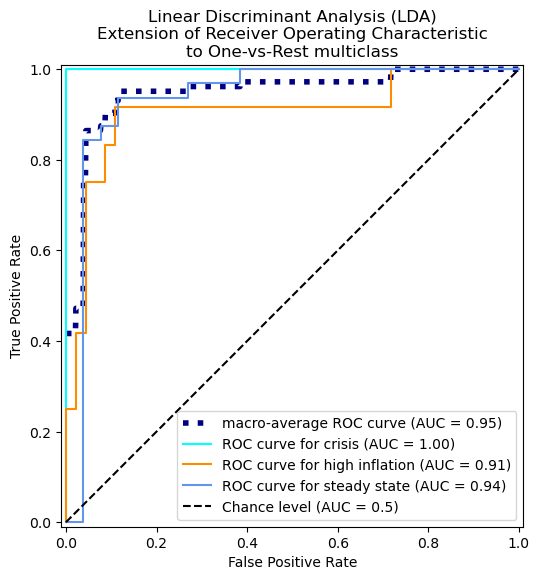

In [88]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, lda, True, "Linear Discriminant Analysis (LDA)")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              11               1             1
high inflation       2               3            11
steady state        13              32            64

       accuracy  macro recall
score  0.565217      0.449505



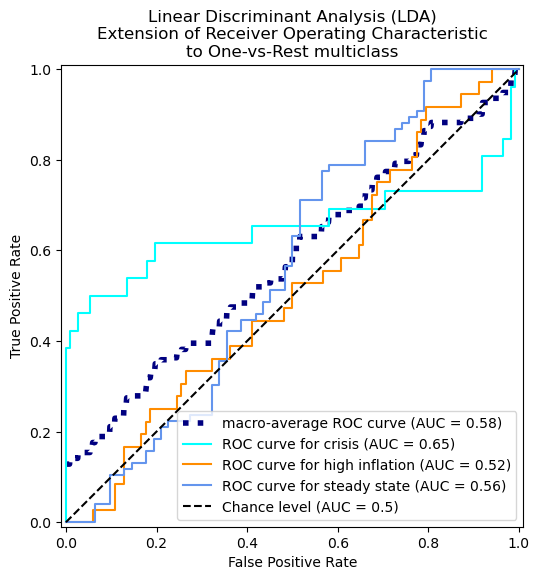

In [89]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, lda, True, "Linear Discriminant Analysis (LDA)")

### Quadratic Discriminant Analysis (QDA)

In [91]:
# Apply QDA
qda = QDA()
qda.fit(Xtrain,Ytrain)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [92]:
# predict the class label
yhat = qda.predict(Xtest)

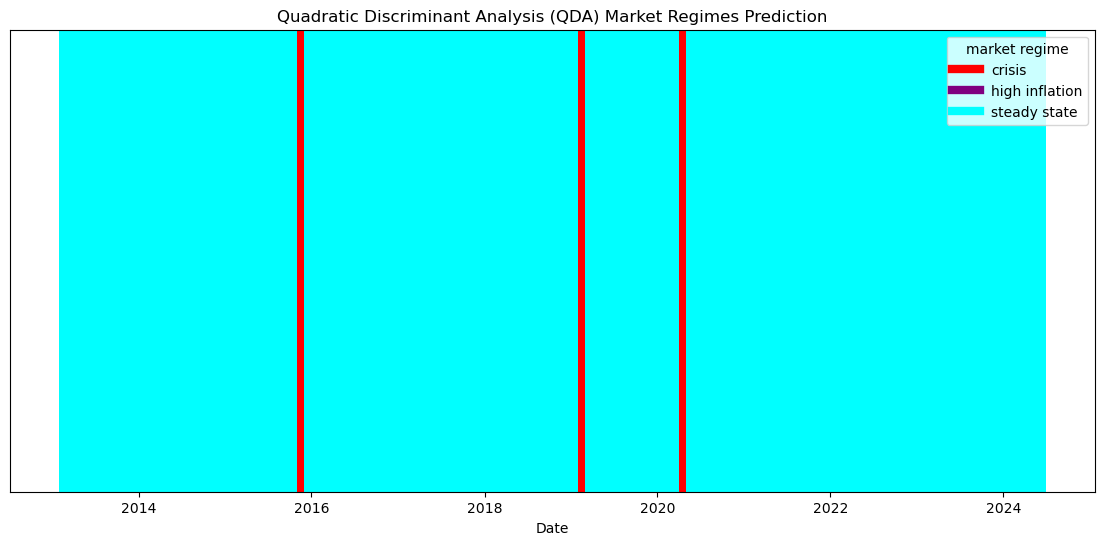

In [93]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Quadratic Discriminant Analysis (QDA) Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

       accuracy  macro recall
score       1.0           1.0



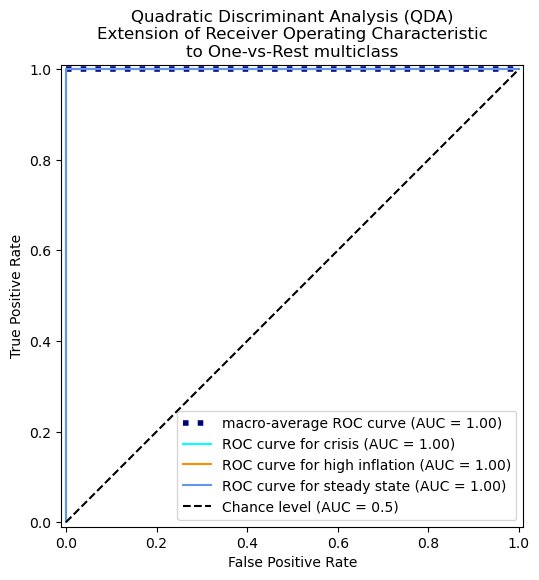

In [94]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, qda, True, "Quadratic Discriminant Analysis (QDA)")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis               3               0             0
high inflation       0               0             0
steady state        23              36            76

       accuracy  macro recall
score  0.572464      0.371795



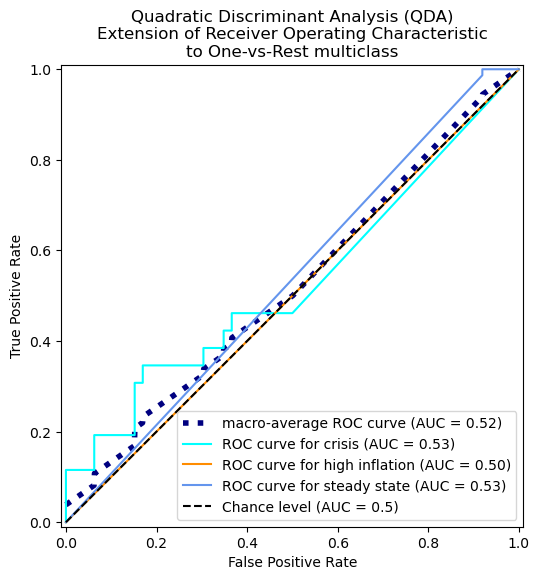

In [95]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, qda, True, "Quadratic Discriminant Analysis (QDA)")

### Gaussian Naive Bayes

In [97]:
# Apply Naive Bayes
NB = GaussianNB()
NB.fit(Xtrain,Ytrain)

GaussianNB()

In [98]:
# predict the class label
yhat = NB.predict(Xtest)

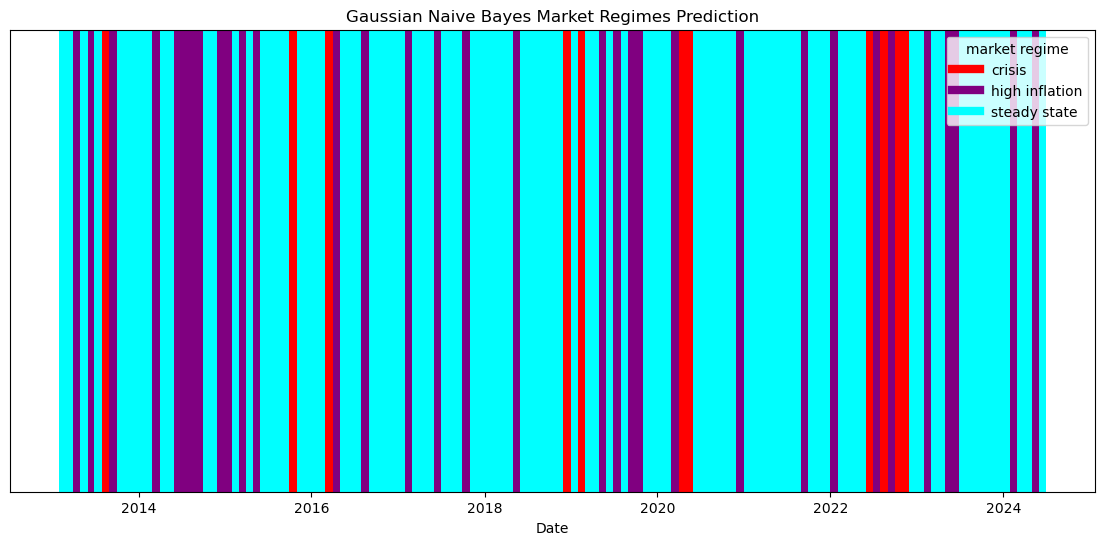

In [99]:
visualise_market_regime(pd.DataFrame({'market regime':yhat}, index=Xtest.index), 'Gaussian Naive Bayes Market Regimes Prediction')

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              10             8
steady state         0               2            24

       accuracy  macro recall
score  0.827586      0.861111



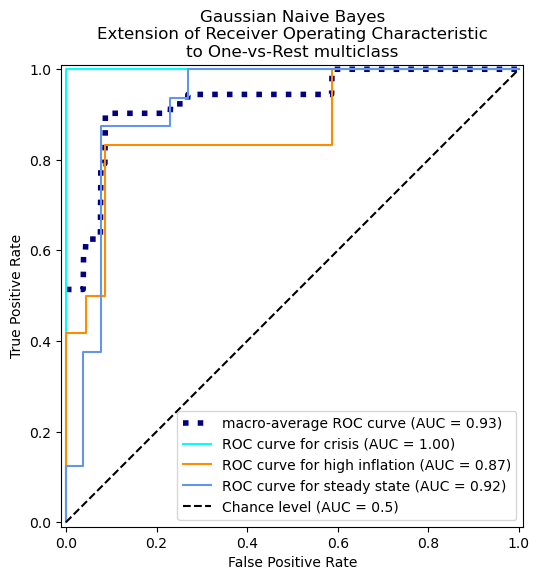

In [100]:
# Train Set Prediction Evaluation
evaluation(Xtrain, Ytrain, NB, True, "Gaussian Naive Bayes")

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              10               0             1
high inflation       5               9            20
steady state        11              27            55

       accuracy  macro recall
score  0.536232      0.452767



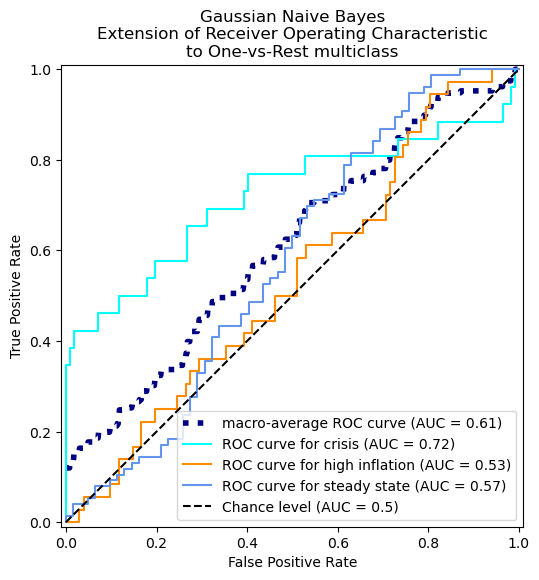

In [101]:
# Test Set Prediction Evaluation
evaluation(Xtest, Ytest, NB, True, "Gaussian Naive Bayes")

# Overall Result
A plot depicting all the Receiver Operating Characteristic (ROC) curves prior to prediction adjustment

In [103]:
# Define model names, model and its colour in the plot
models = {'Multinominal Logistic Regression':[MLRcv, 'tab:blue'], 
          'K-Nearest Neighbours':[knnCV, 'tab:orange'],
         'Decision Tree': [treeCV,'tab:green'], 
          'Random Forest':[rfCV,'tab:red'], 
          'AdaBoost':[adaCV,'tab:purple'], 
          'Gradient Boosting':[grdCV,'tab:brown'],
         'Support Vector Machines (SVMs)': [svmCV,'tab:pink'], 
          'Linear Discriminant Analysis (LDA)':[lda,'tab:gray'],
         'Quadratic Discriminant Analysis (QDA)': [qda,'tab:olive'], 
          'Gaussian Naive Bayes': [NB,'tab:cyan']}

def all_ROC_AUC(models, Xdata, Ydata, title):
    # Set the layout of the plot
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Binarize labels in a one-vs-all fashion
    label_binarizer = LabelBinarizer().fit(Ytrain)
    y_onehot = label_binarizer.transform(Ydata)

    n_classes = len(np.unique(Ytrain))
    
    # plot each model
    for model in models.keys():
        # store the fpr, tpr, and roc_auc for all averaging strategies
        fpr, tpr, roc_auc = dict(), dict(), dict()
        
        y_score = models[model][0].fit(Xtrain, Ytrain).predict_proba(Xdata)

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)
        
        for i in range(n_classes):
            mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
        
        # Average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = fpr_grid
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"{model} (AUC = {roc_auc['macro']:.2f})",
        color=models[model][1],
        linestyle=":",
        linewidth=4,
    )
    
    # Show the chance level line at random guess
    plt.plot([0, 1], [0, 1],'k--')
    
    # Set the labels and title
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )
    
    # Show the legend
    plt.legend(loc = 'lower right')
    
    # Set the limit of axis
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    # Plot
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


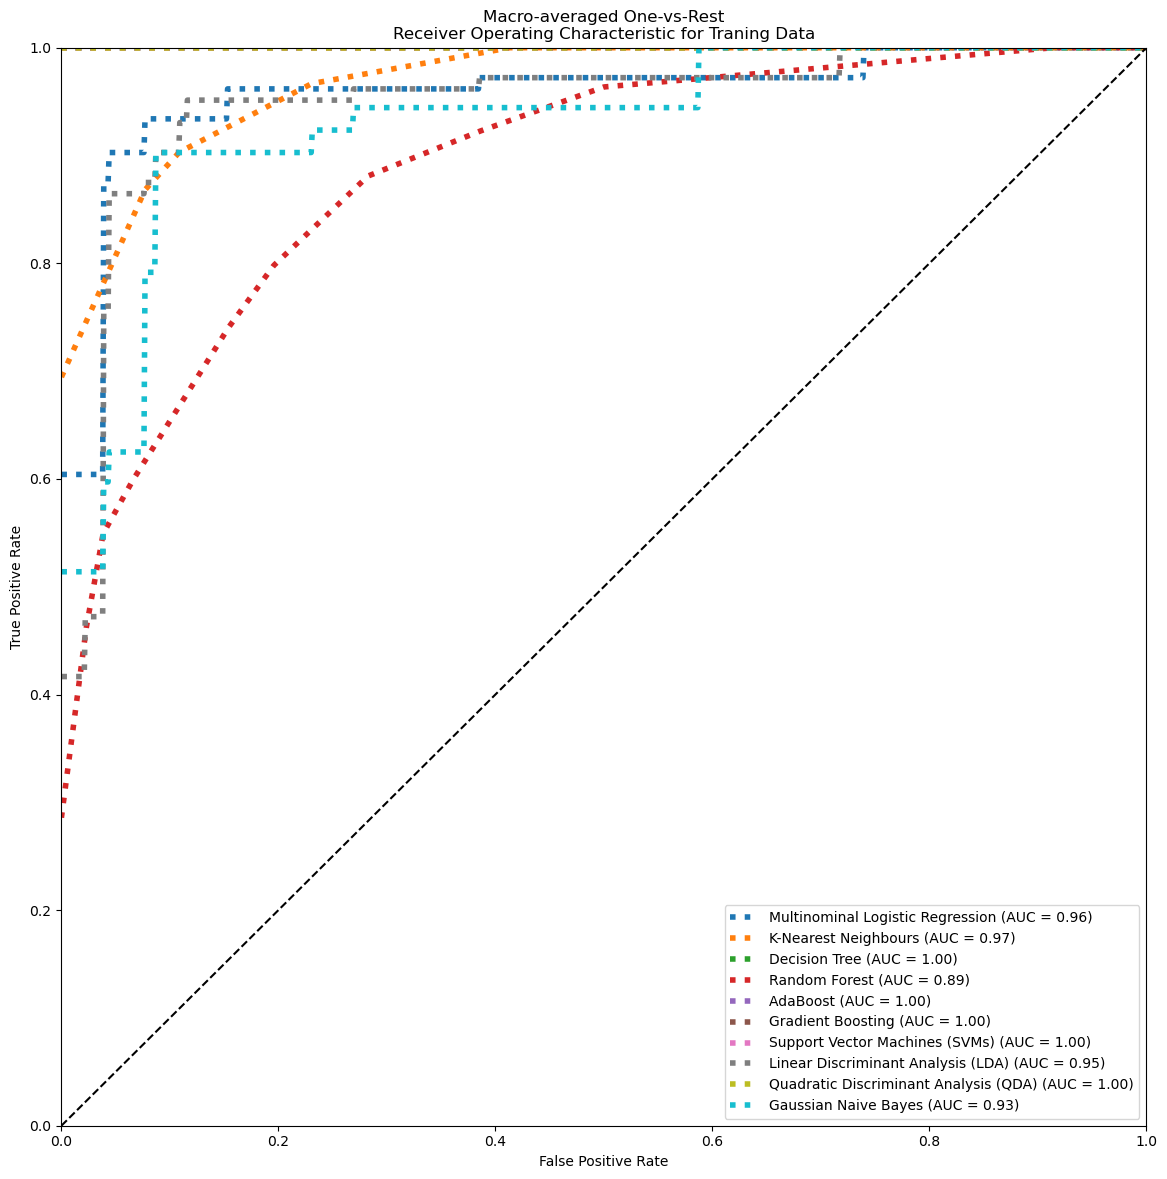

In [104]:
all_ROC_AUC(models, Xtrain, Ytrain, "Macro-averaged One-vs-Rest\nReceiver Operating Characteristic for Traning Data")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


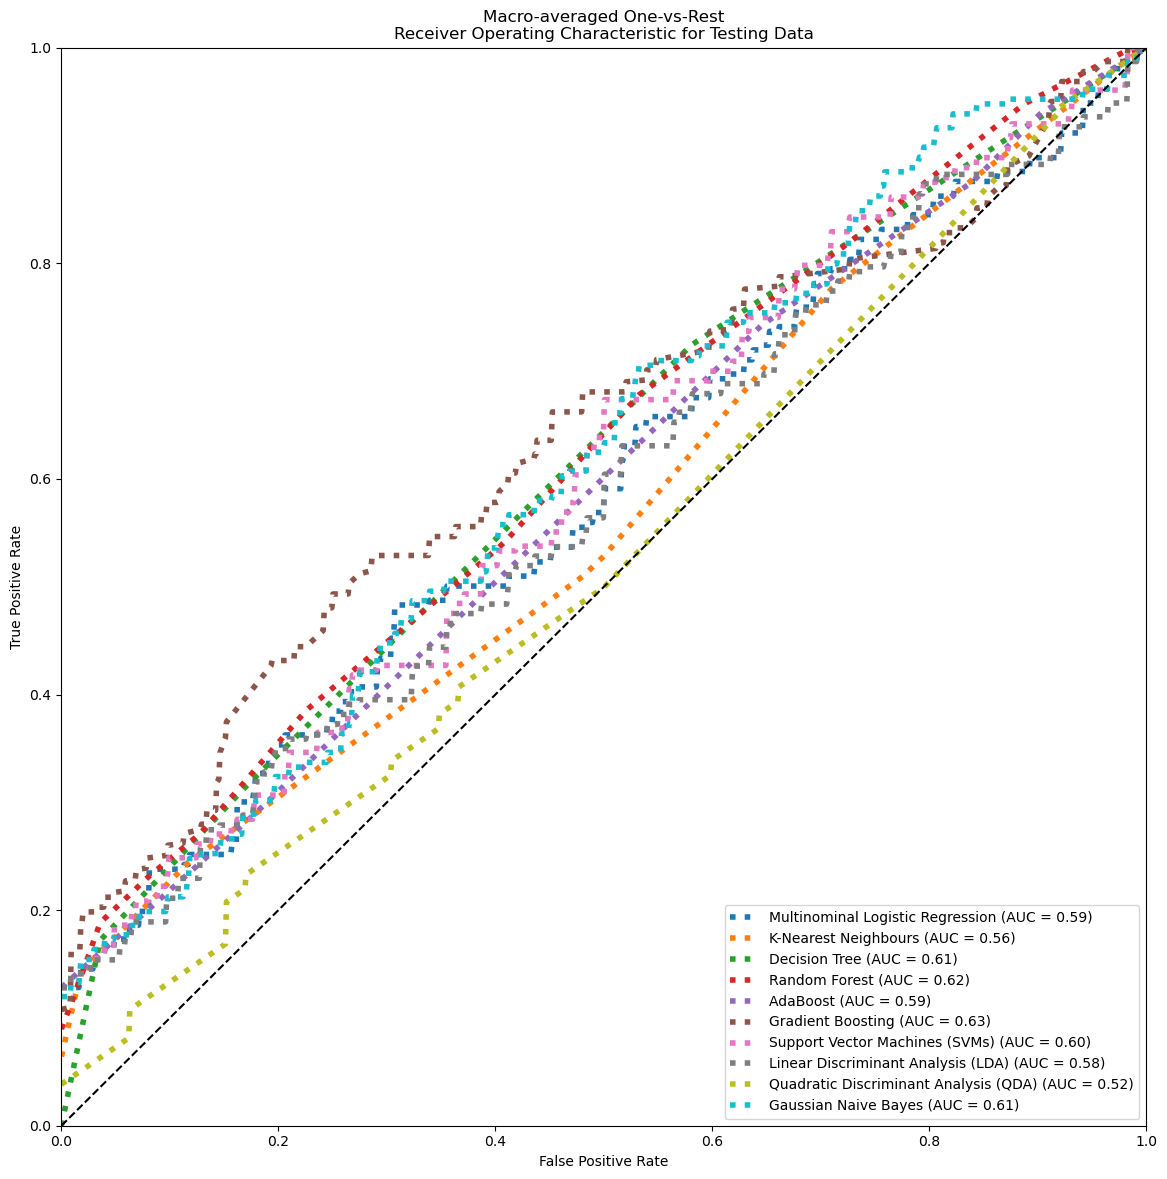

In [105]:
all_ROC_AUC(models, Xtest, Ytest, "Macro-averaged One-vs-Rest\nReceiver Operating Characteristic for Testing Data")

# Ensemble Model

In [107]:
def ensembled_model_prediction(data, probability: bool):
    """
    data: features for prediction
    probability: return the probability estimate or return the label
    """
    # Create DataFrame containing relevant models' predicitons
    predictions = pd.DataFrame({#'logistic':MLRcv.predict(data),
                                #'knn':knnCV.predict(data),
                                'decision tree':treeCV.predict(data),
                                #'random forest': rfCV.predict(data),
                                #'adaboost': adaCV.predict(data),
                                # 'gradientboost': grdCV.predict(data),
                                #'SVM': svmCV.predict(data),
                                #'LDA':lda.predict(data),
                                'QDA':qda.predict(data),
                                'NB':NB.predict(data)
                               }, index = data.index)

    if probability:
        # create the dataframe to store the predicted probability of each market regime on each date
        prob = pd.DataFrame(0, index=data.index, columns=regime_colors.keys())

        # loop the predictions and count the occurrence of each market regime
        for d in predictions.index:
            for m in predictions.columns:
                if predictions.loc[d,m] == 'steady state':
                   prob.loc[d,'steady state'] += 1
                elif predictions.loc[d,m] == 'crisis':
                    prob.loc[d,'crisis'] += 1
                elif predictions.loc[d,m] == 'high inflation':
                    prob.loc[d,'high inflation'] += 1
                else:
                    raise Exception('wrong market regime!!')

        # divide by the number of models used
        prob = (prob/len(predictions.columns)).to_numpy()
        return prob
        
    # Select the mode on each day
    predictions = predictions.mode(axis=1)
    
    # Drop unwanted columns
    predictions.dropna(axis=1, inplace=True)
    
    # Rename the column as 'market regime'
    predictions.columns = ['market regime']

    # Add the date of the prediction
    predictions.index = data.index

    return predictions


In [108]:
def ensemble_evaluation(prediction, data):
    # Confusion Table
    print(confusion_table(prediction, data))
    
    # Accuracy
    print(f"\naccuracy: {accuracy_score(data, prediction):.4f}")
        
    # Macro-precision
    print(f"Macro Recall: {recall_score(data, prediction, labels=prediction['market regime'].unique(),average='macro',zero_division=np.nan):.4f}")

In [109]:
# Note that the visualisation is meaningless because the training dataset is reduced by ENN and most of the dates are missing.
# So it is not plotted
ensembled_train = ensembled_model_prediction(Xtrain,False)
ensemble_evaluation(ensembled_train, Ytrain)

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              14               0             0
high inflation       0              12             0
steady state         0               0            32

accuracy: 1.0000
Macro Recall: 1.0000


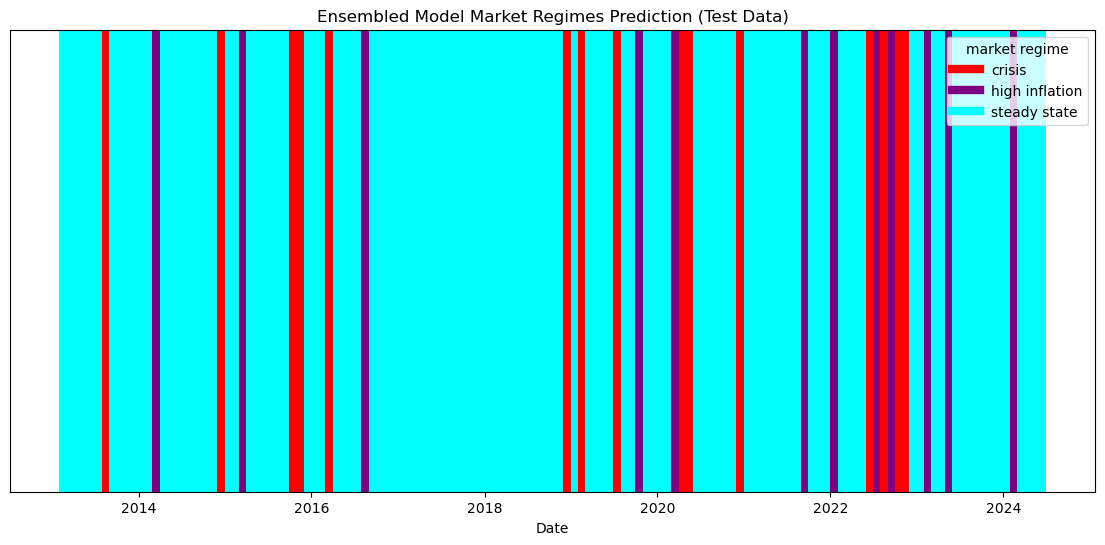

In [110]:
ensembled_test = ensembled_model_prediction(Xtest,False)
visualise_market_regime(ensembled_test, 'Ensembled Model Market Regimes Prediction (Test Data)')

In [111]:
ensemble_evaluation(ensembled_test, Ytest)

Truth           crisis  high inflation  steady state
Predicted                                           
crisis              12               1             2
high inflation       3               4             5
steady state        11              31            69

accuracy: 0.6159
Macro Recall: 0.4935


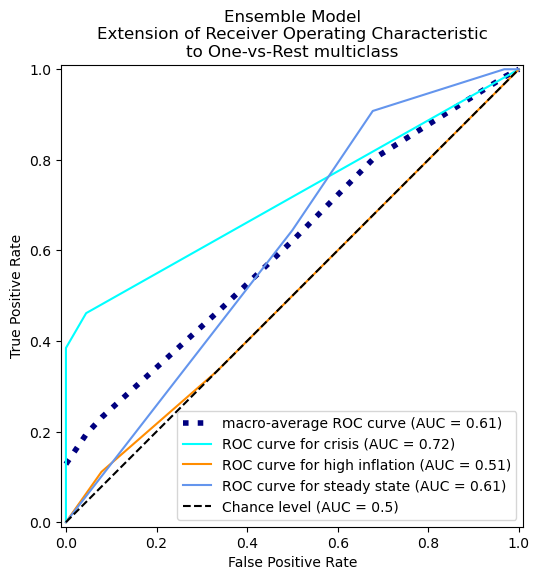

In [112]:
individual_model_macro_ROC(Xtest,Ytest, None, "Ensemble Model", True)